### Random forest

Here we train three random forests, one for each of the fire types. We feed them through an sklearn pipeline, save them and plot graphs of feature importance and ROC curves. There is also some investiagation of recall and precision curves

In [93]:
#Modelling tools contains custom functions
import Modelling_tools as MT
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
#This will be useful for assessing the model performance
from sklearn import metrics

In [16]:
#For saving the final models
import pickle

In [4]:
dataset = pd.read_csv("/Users/rmartinshort/Documents/Insight/Project/census_block_prediction/Fully_merged_dataset_Autogenerated_plus.csv")

In [5]:
#Do something about the NaNs (~10% of dataset)
#Where we don't have information about the property, fill
#unknownusetype and set proportions of use types to zero
#Then set the remaining Na values to be the mean 

#In practice the model output does not change much no matter
#what we value we choose to fill them with. Its also possible to train
#a model without NaNs, but then we end up with missing blocks
#in the web app 

dataset['UnkownUseType'].fillna(1,inplace=True)
dataset['S'].fillna(1,inplace=True)
values = {'COMH':0, 'COMM':0, 'COMO':0, 'COMR':0, 'GOVT':0, 'IND':0, 'MISC':0,
       'MRES':0, 'SRES':0, 'A':0, 'B':0, 'C':0, 'D':0}
dataset = dataset.fillna(value=values)
dataset.fillna(dataset.mean(),inplace=True)

In [6]:
dataset.drop(['IDyear_x.1'],inplace=True,axis=1)

In [9]:
test_parameters_RF = {
        'classify__n_estimators': (50,100),
        'classify__max_depth': (5,10,20),
        'classify__min_samples_leaf':(50,80),
        'classify__class_weight':('balanced','balanced_subsample')
}

In [1]:
test_parameters_RF = {
        'classify__n_estimators': (200,300),
        'classify__max_depth': (5,10,20),
        'classify__min_samples_leaf':(10,20,50),
        'classify__class_weight':('balanced','balanced_subsample')
}

### External fires

In [7]:
X,y,Xholdout,yholdoutEF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='EF_pred',yearto_holdout=2018)

In [8]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [9]:
#Run grid search for the best model
Xcols_EF, RC_model_EF = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (200, 300), 'classify__max_depth': (5, 10, 20), 'classify__min_samples_leaf': (10, 20, 50), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed: 22.2min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1348.876s

Best score: 0.843
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 20
	classify__min_samples_leaf: 50
	classify__n_estimators: 200


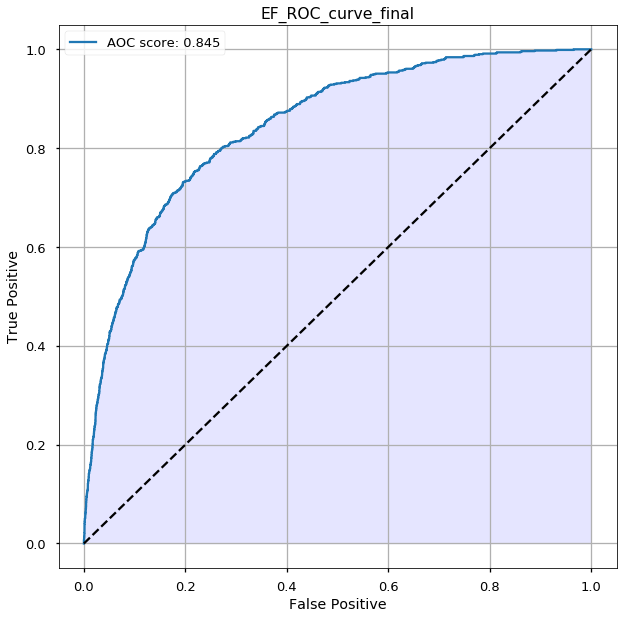

In [12]:
ROCplot, false_positive_EF, true_positive_EF, thresholds_SF = MT.plot_ROC_curve(Xholdout,yholdoutEF,RC_model_EF,
                                                                                title='EF_ROC_curve_final')

In [13]:
fprobs = RC_model_EF.predict_proba(Xholdout)

In [19]:
fclass = RC_model_EF.predict(Xholdout)

This is reasonable: With a theshold of 0.5 we catch the majority of the external fires, but we end up flagging too many cells, so the precision is low. We need to raise the threshold if we want to designate a useful proportion of the city

In [32]:
metrics.recall_score(yholdoutEF,fclass)

0.7684729064039408

In [31]:
metrics.precision_score(yholdoutEF,fclass)

0.287292817679558

In [33]:
metrics.f1_score(yholdoutEF,fclass)

0.41823056300268097

These numbers are interesting and useful from a storytelling perspective: The model has high recall (flags the majority of blocks that will contain fires) but low precision (many of the blocks it flags don't have fires) at a threshold of 0.5. To combat this, we need to have some reasonable way of raising the threshold - and we can do this using the mean cell method

In [34]:
feature_importances = RC_model_EF.named_steps['classify'].feature_importances_

In [35]:
inds = feature_importances.argsort()[::-1]

In [36]:
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols_EF[index])

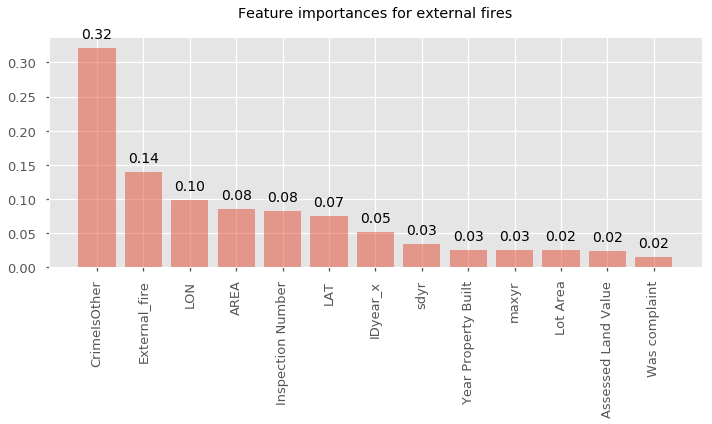

In [37]:
plt.style.use('ggplot')
xlabels = fnames
ylabels = fvals

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances for external fires",pad=20)
plt.tight_layout()
plt.savefig("External_fires_fimportance_final.png",dpi=400)

### Vehicle fires

In [38]:
X,y,Xholdout,yholdoutVF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='VF_pred',yearto_holdout=2018)

In [39]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [40]:
#Run grid search for the best model
Xcols_VF, RC_model_VF = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (200, 300), 'classify__max_depth': (5, 10, 20), 'classify__min_samples_leaf': (10, 20, 50), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed: 23.5min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1432.962s

Best score: 0.767
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 20
	classify__min_samples_leaf: 50
	classify__n_estimators: 200


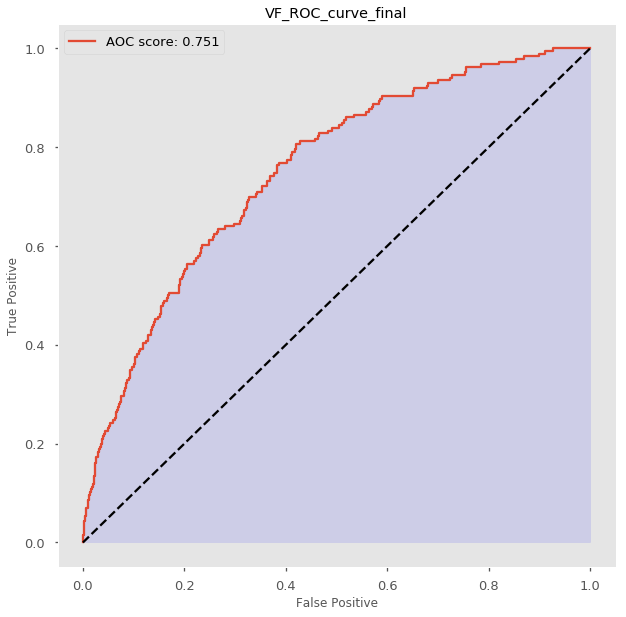

In [60]:
ROCplot, false_positive_VF, true_positive_EF, thresholds_VF = MT.plot_ROC_curve(Xholdout,yholdoutVF,RC_model_VF,
                                                                               title='VF_ROC_curve_final')

In [90]:
fprobsvh = RC_model_VF.predict_proba(Xholdout)
fclassvh = RC_model_VF.predict(Xholdout)

These are the recall and precision scores for a threshold of 0.5. They're not great! But this is to be expected

In [91]:
metrics.recall_score(yholdoutVF,fclassvh)

0.42473118279569894

In [92]:
metrics.precision_score(yholdoutVF,fclassvh)

0.07610789980732177

In [66]:
feature_importances = RC_model_VF.named_steps['classify'].feature_importances_

In [67]:
inds = feature_importances.argsort()[::-1]

In [68]:
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols_VF[index])

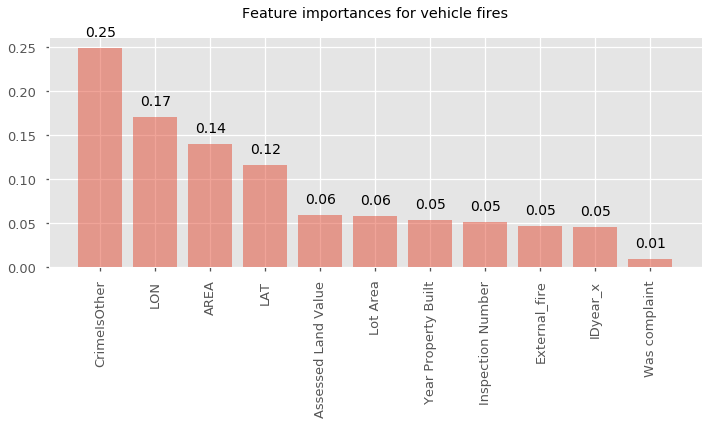

In [69]:
plt.style.use('ggplot')
xlabels = fnames
ylabels = fvals

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances for vehicle fires",pad=20)
plt.tight_layout()
plt.savefig("Vehicle_fires_fimportance_final.png",dpi=400)

In [70]:
X,y,Xholdout,yholdoutSF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='SF_pred',yearto_holdout=2018)

In [71]:
pipeline, gridsearch, testparams = MT.generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

In [72]:
#Run grid search for the best model
Xcols_SF, RC_model_SF = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': (200, 300), 'classify__max_depth': (5, 10, 20), 'classify__min_samples_leaf': (10, 20, 50), 'classify__class_weight': ('balanced', 'balanced_subsample')}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed: 21.9min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


done in 1338.026s

Best score: 0.809
Best parameters set:
	classify__class_weight: 'balanced_subsample'
	classify__max_depth: 20
	classify__min_samples_leaf: 50
	classify__n_estimators: 300


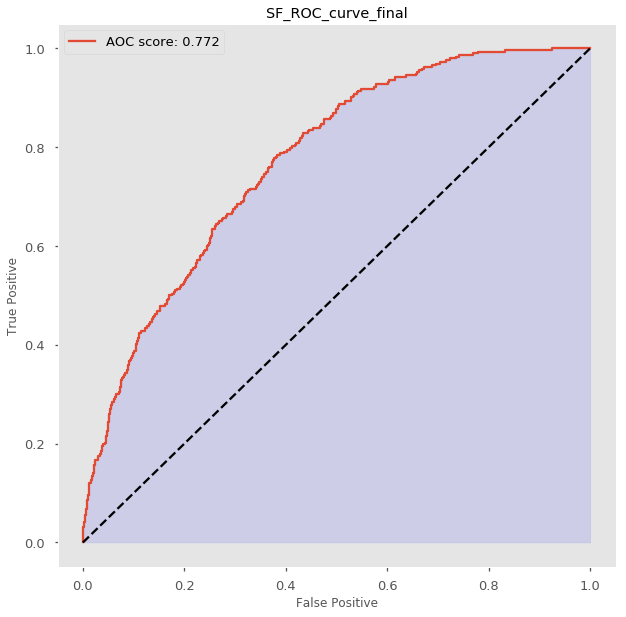

In [74]:
ROCplot, false_positive_SF, true_positive_SF, thresholds_VF = MT.plot_ROC_curve(Xholdout,yholdoutSF,RC_model_SF,
                                                                               title='SF_ROC_curve_final')

In [78]:
fprobssf = RC_model_SF.predict_proba(Xholdout)
fclasssf = RC_model_SF.predict(Xholdout)

These are the recall and precision scores for a threshold of 0.5. They're not great! But this is to be expected

In [79]:
metrics.recall_score(yholdoutSF,fclasssf)

0.4794520547945205

In [80]:
metrics.precision_score(yholdoutSF,fclasssf)

0.11067193675889328

In [81]:
feature_importances = RC_model_SF.named_steps['classify'].feature_importances_

In [82]:
inds = feature_importances.argsort()[::-1]

In [83]:
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols_SF[index])

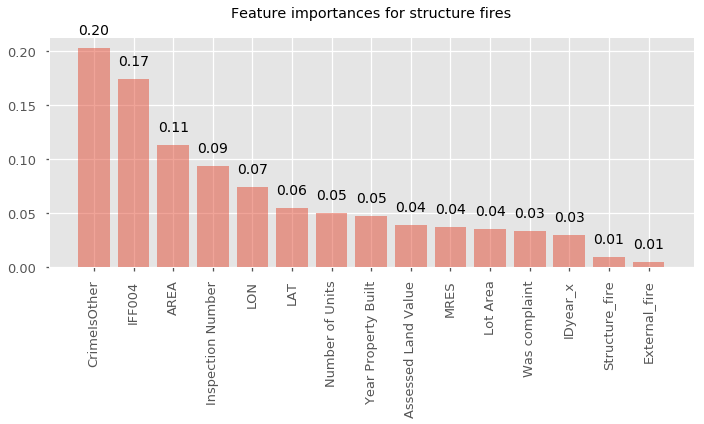

In [85]:
plt.style.use('ggplot')
xlabels = fnames
ylabels = fvals

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances for structure fires",pad=20)
plt.tight_layout()
plt.savefig("Structure_fires_fimportance_final.png",dpi=400)

### Save the models

In [86]:
filename = 'Model_RC_SF_new.sav'
pickle.dump(RC_model_SF, open(filename, 'wb'))

In [87]:
filename = 'Model_RC_VF_new.sav'
pickle.dump(RC_model_VF, open(filename, 'wb'))

In [88]:
filename = 'Model_RC_EF_new.sav'
pickle.dump(RC_model_EF, open(filename, 'wb'))